First, install the dependencies after setting up python venv with:
```
uv sync
```
and select the `.venv` as the kernel.

## 1. Download the trailer dataset
We will use YouTube API to automatically download the trailers from YouTube. However, to ensure that the movie selection is without biases, we will first subsample movie trailers from the `Trailer12k` [dataset](https://richardtml.github.io/trailers12k/), getting 3 films for all genres. Then, we will look up YouTube to download the files accordingly.

First, we will import the libraries and sample the metadata from the dataset. The `mtgc.csv` file contains the movie id (mid), its type (i.e., horror, drama, etc.) as one-hot encoded vector, and split0 (train), split1 (val), and split2 (test).

In [3]:
import pandas as pd

# Set random seed for reproducibility
seed_num = 42

# Read the dataset
df = pd.read_csv('data/mtgc.csv')

# List of all genres
genres = ['action', 'adventure', 'comedy', 'crime', 'drama', 
          'fantasy', 'horror', 'romance', 'sci-fi', 'thriller']

# Create an empty DataFrame to store our sampled movies
sampled_movies = []

# For each genre, sample 3 movies that have that genre
for genre in genres:
    # Get movies that have this genre (where genre column is 1)
    genre_movies = df[df[genre] == 1]
    
    # Sample 3 movies randomly
    sampled = genre_movies.sample(n=3, random_state=seed_num)
    
    # Add to our list
    sampled_movies.append(sampled)

# Combine all sampled movies
final_sample = pd.concat(sampled_movies).drop_duplicates()

# Save the sampled dataset
final_sample.to_csv('data/sampled_trailers.csv', index=False)

# Print some statistics
print(f"Total number of movies in sample: {len(final_sample)}")
print("\nNumber of movies per genre:")
for genre in genres:
    print(f"\n{genre}: {sum(final_sample[genre])}")
    print("Movie IDs:", final_sample[final_sample[genre] == 1]['mid'].tolist())

Total number of movies in sample: 30

Number of movies per genre:

action: 7
Movie IDs: ['tt1733578', 'tt1217613', 'tt0437459', 'tt7639528', 'tt4076934', 'tt2283362', 'tt0435716']

adventure: 6
Movie IDs: ['tt4470288', 'tt3146360', 'tt7639528', 'tt1037156', 'tt0379557', 'tt2283362']

comedy: 9
Movie IDs: ['tt4470288', 'tt7639528', 'tt4270878', 'tt1037156', 'tt0243736', 'tt0373981', 'tt2283362', 'tt0372122', 'tt0255798']

crime: 6
Movie IDs: ['tt0437459', 'tt1037156', 'tt0373981', 'tt1670345', 'tt4076934', 'tt0884335']

drama: 17
Movie IDs: ['tt0437459', 'tt3146360', 'tt1037156', 'tt0373981', 'tt4076934', 'tt2935476', 'tt0379557', 'tt0903657', 'tt8092252', 'tt0772176', 'tt2620736', 'tt0372122', 'tt0435716', 'tt1798709', 'tt0466375', 'tt3616916', 'tt0884335']

fantasy: 4
Movie IDs: ['tt4470288', 'tt8092252', 'tt2283362', 'tt0772176']

horror: 6
Movie IDs: ['tt1733578', 'tt1789724', 'tt2620736', 'tt0810444', 'tt3655682', 'tt1285217']

romance: 8
Movie IDs: ['tt4270878', 'tt0243736', 'tt03

Now that we have the movie IDs, we will use this identifier to get the YouTube IDs from the `metadata.json` and download the corresponding trailers using Python API. (Alternative is to use `.zarr` representation for pure features, but that is suitable mainly only to the genre classification task). The resulting trailers are saved in the folder `data/trailers`.

In [45]:
# Read your sampled movies
sampled_df = pd.read_csv('data/sampled_trailers.csv')
movie_ids = sampled_df['mid'].tolist()
# print(movie_ids)

# Remove 'tt' from the beginning of the movie IDs
movie_ids = [id.replace('tt', '') for id in movie_ids]
print(movie_ids)

# Using metadata.json to get YouTube IDs
import json

# Load metadata
with open('data/metadata.json', 'r') as f:
    metadata = json.load(f)

# Inspect the metadata
print(len(metadata['trailers12k'].keys())) # 12000, number of trailers

# In metadata['trailers12k']['1'], there are 2 keys: 'imdb' and 'youtube'
# The result of metadata['trailers12k']['1']['youtube'] is 
# {'trailers': [{'id': '6FeyhlLZYrg', 'dims': [99.12, 360, 640]}]}
# for mid, use metadata['trailers12k']['1']['imdb']['id']
# for key in metadata['trailers12k']['1'].keys():
#     print(key)
#     print(metadata['trailers12k']['1'][key])

# Create a hash map to store movie_id -> database_id mapping
id_mapping = {}
for db_id in metadata['trailers12k'].keys():
    movie_id = metadata['trailers12k'][db_id]['imdb']['id']
    id_mapping[movie_id] = db_id

print(f"Created mapping for {len(id_mapping)} movies")
# print("First 5 entries of the mapping:")
# for db_id, movie_id in list(id_mapping.items())[:5]:
#     print(f"Database ID: {db_id}, Movie ID: {movie_id}")



print("Getting YouTube IDs...")
youtube_movie_ids_map = {}
for movie_id in movie_ids:
    if movie_id in id_mapping:
        db_id = id_mapping[movie_id]
        youtube_id = metadata['trailers12k'][db_id]['youtube']['trailers'][0]['id']
        youtube_movie_ids_map[youtube_id] = movie_id
    else:
        print(f"Movie ID {movie_id} not found in mapping")
print(f"Successfully got {len(youtube_movie_ids_map)} YouTube IDs:")
# Now you can download videos using youtube-dl or similar tools

['1733578', '1217613', '0437459', '4470288', '3146360', '7639528', '4270878', '1037156', '0243736', '0373981', '1670345', '4076934', '2935476', '0379557', '0903657', '8092252', '2283362', '0772176', '1789724', '2620736', '0810444', '0372122', '0435716', '1798709', '3655682', '0255798', '0466375', '3616916', '1285217', '0884335']
12000
Created mapping for 12000 movies
Getting YouTube IDs...
Successfully got 30 YouTube IDs:


In [23]:
import yt_dlp

def download_trailer(youtube_id, output_path):
    ydl_opts = {
        'format': 'best',  # or specify format like 'bestvideo[height<=720]+bestaudio/best[height<=720]'
        'outtmpl': f'{output_path}/%(id)s.%(ext)s',
    }
    
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        try:
            ydl.download([f'https://www.youtube.com/watch?v={youtube_id}'])
            return True
        except:
            print(f"Could not download video {youtube_id}")
            return False

# Create output directory
import os
os.makedirs('data/trailers', exist_ok=True)

# Download all trailers
for youtube_id in youtube_ids:
    download_trailer(youtube_id, 'data/trailers')

[youtube] Extracting URL: https://www.youtube.com/watch?v=OMKbS5-jIjw
[youtube] OMKbS5-jIjw: Downloading webpage
[youtube] OMKbS5-jIjw: Downloading tv client config
[youtube] OMKbS5-jIjw: Downloading player 179bab65-main
[youtube] OMKbS5-jIjw: Downloading tv player API JSON
[youtube] OMKbS5-jIjw: Downloading ios player API JSON


ERROR: [youtube] OMKbS5-jIjw: Video unavailable. This video contains content from Talent Web Academy, who has blocked it in your country on copyright grounds


Could not download video OMKbS5-jIjw
[youtube] Extracting URL: https://www.youtube.com/watch?v=Yt7ofokzn04
[youtube] Yt7ofokzn04: Downloading webpage
[youtube] Yt7ofokzn04: Downloading tv client config
[youtube] Yt7ofokzn04: Downloading player 179bab65-main
[youtube] Yt7ofokzn04: Downloading tv player API JSON
[youtube] Yt7ofokzn04: Downloading ios player API JSON
[youtube] Yt7ofokzn04: Downloading m3u8 information
[info] Yt7ofokzn04: Downloading 1 format(s): 18
[download] Destination: data/trailers/Yt7ofokzn04.mp4
[download] 100% of    6.62MiB in 00:00:00 at 7.91MiB/s   
[youtube] Extracting URL: https://www.youtube.com/watch?v=9-UY5VgHHXA
[youtube] 9-UY5VgHHXA: Downloading webpage
[youtube] 9-UY5VgHHXA: Downloading tv client config
[youtube] 9-UY5VgHHXA: Downloading player 179bab65-main
[youtube] 9-UY5VgHHXA: Downloading tv player API JSON
[youtube] 9-UY5VgHHXA: Downloading ios player API JSON


ERROR: [youtube] 9-UY5VgHHXA: Video unavailable


Could not download video 9-UY5VgHHXA
[youtube] Extracting URL: https://www.youtube.com/watch?v=suJhUxvLUDE
[youtube] suJhUxvLUDE: Downloading webpage
[youtube] suJhUxvLUDE: Downloading tv client config
[youtube] suJhUxvLUDE: Downloading player 179bab65-main
[youtube] suJhUxvLUDE: Downloading tv player API JSON
[youtube] suJhUxvLUDE: Downloading ios player API JSON
[youtube] suJhUxvLUDE: Downloading m3u8 information
[info] suJhUxvLUDE: Downloading 1 format(s): 18
[download] Destination: data/trailers/suJhUxvLUDE.mp4
[download] 100% of    6.94MiB in 00:00:05 at 1.20MiB/s   
[youtube] Extracting URL: https://www.youtube.com/watch?v=MNQiLB2Rdjs
[youtube] MNQiLB2Rdjs: Downloading webpage
[youtube] MNQiLB2Rdjs: Downloading tv client config
[youtube] MNQiLB2Rdjs: Downloading player 179bab65-main
[youtube] MNQiLB2Rdjs: Downloading tv player API JSON
[youtube] MNQiLB2Rdjs: Downloading ios player API JSON
[youtube] MNQiLB2Rdjs: Downloading m3u8 information
[info] MNQiLB2Rdjs: Downloading 1 forma

ERROR: [youtube] xwk3RJ_PVxE: Video unavailable


Could not download video xwk3RJ_PVxE
[youtube] Extracting URL: https://www.youtube.com/watch?v=9scyo1fQXbc
[youtube] 9scyo1fQXbc: Downloading webpage
[youtube] 9scyo1fQXbc: Downloading tv client config
[youtube] 9scyo1fQXbc: Downloading player 64be519f-main
[youtube] 9scyo1fQXbc: Downloading tv player API JSON
[youtube] 9scyo1fQXbc: Downloading ios player API JSON
[youtube] 9scyo1fQXbc: Downloading m3u8 information
[info] 9scyo1fQXbc: Downloading 1 format(s): 18
[download] Destination: data/trailers/9scyo1fQXbc.mp4
[download] 100% of    8.15MiB in 00:00:04 at 1.85MiB/s   
[youtube] Extracting URL: https://www.youtube.com/watch?v=oMDXmDOyWE8
[youtube] oMDXmDOyWE8: Downloading webpage
[youtube] oMDXmDOyWE8: Downloading tv client config
[youtube] oMDXmDOyWE8: Downloading player 179bab65-main
[youtube] oMDXmDOyWE8: Downloading tv player API JSON
[youtube] oMDXmDOyWE8: Downloading ios player API JSON
[youtube] oMDXmDOyWE8: Downloading m3u8 information
[info] oMDXmDOyWE8: Downloading 1 forma

ERROR: [youtube] y3qhbh9lDko: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Could not download video y3qhbh9lDko
[youtube] Extracting URL: https://www.youtube.com/watch?v=LSrBBhedXVE
[youtube] LSrBBhedXVE: Downloading webpage
[youtube] LSrBBhedXVE: Downloading tv client config
[youtube] LSrBBhedXVE: Downloading player 179bab65-main
[youtube] LSrBBhedXVE: Downloading tv player API JSON
[youtube] LSrBBhedXVE: Downloading ios player API JSON
[youtube] LSrBBhedXVE: Downloading m3u8 information
[info] LSrBBhedXVE: Downloading 1 format(s): 18
[download] Destination: data/trailers/LSrBBhedXVE.mp4
[download] 100% of   10.66MiB in 00:00:06 at 1.71MiB/s     
[youtube] Extracting URL: https://www.youtube.com/watch?v=hrt7uSLIiyk
[youtube] hrt7uSLIiyk: Downloading webpage
[youtube] hrt7uSLIiyk: Downloading tv client config
[youtube] hrt7uSLIiyk: Downloading player 179bab65-main
[youtube] hrt7uSLIiyk: Downloading tv player API JSON
[youtube] hrt7uSLIiyk: Downloading ios player API JSON
[youtube] hrt7uSLIiyk: Downloading m3u8 information
[info] hrt7uSLIiyk: Downloading 1 for

ERROR: [youtube] WGSvhDcimJg: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Could not download video WGSvhDcimJg
[youtube] Extracting URL: https://www.youtube.com/watch?v=o-mGxa-_85M
[youtube] o-mGxa-_85M: Downloading webpage
[youtube] o-mGxa-_85M: Downloading tv client config
[youtube] o-mGxa-_85M: Downloading player 179bab65-main
[youtube] o-mGxa-_85M: Downloading tv player API JSON
[youtube] o-mGxa-_85M: Downloading ios player API JSON
[youtube] o-mGxa-_85M: Downloading m3u8 information
[info] o-mGxa-_85M: Downloading 1 format(s): 18
[download] Destination: data/trailers/o-mGxa-_85M.mp4
[download] 100% of    5.13MiB in 00:00:03 at 1.66MiB/s     
[youtube] Extracting URL: https://www.youtube.com/watch?v=c4vCtn5RMKo
[youtube] c4vCtn5RMKo: Downloading webpage
[youtube] c4vCtn5RMKo: Downloading tv client config
[youtube] c4vCtn5RMKo: Downloading player 179bab65-main
[youtube] c4vCtn5RMKo: Downloading tv player API JSON
[youtube] c4vCtn5RMKo: Downloading ios player API JSON
[youtube] c4vCtn5RMKo: Downloading m3u8 information
[info] c4vCtn5RMKo: Downloading 1 for

ERROR: [youtube] WzV6mXIOVl4: Video unavailable


Could not download video WzV6mXIOVl4
[youtube] Extracting URL: https://www.youtube.com/watch?v=HXI_xAJFi4Q
[youtube] HXI_xAJFi4Q: Downloading webpage
[youtube] HXI_xAJFi4Q: Downloading tv client config
[youtube] HXI_xAJFi4Q: Downloading player 64be519f-main
[youtube] HXI_xAJFi4Q: Downloading tv player API JSON
[youtube] HXI_xAJFi4Q: Downloading ios player API JSON
[youtube] HXI_xAJFi4Q: Downloading m3u8 information
[info] HXI_xAJFi4Q: Downloading 1 format(s): 18
[download] Destination: data/trailers/HXI_xAJFi4Q.mp4
[download] 100% of    5.40MiB in 00:00:03 at 1.56MiB/s   
[youtube] Extracting URL: https://www.youtube.com/watch?v=pBwcksgKcFs
[youtube] pBwcksgKcFs: Downloading webpage
[youtube] pBwcksgKcFs: Downloading tv client config
[youtube] pBwcksgKcFs: Downloading player 179bab65-main
[youtube] pBwcksgKcFs: Downloading tv player API JSON
[youtube] pBwcksgKcFs: Downloading ios player API JSON
[youtube] pBwcksgKcFs: Downloading m3u8 information
[info] pBwcksgKcFs: Downloading 1 forma

Due to copyright issues, or private videos, some trailers were not downloadable.

In [26]:
path = 'data/trailers'
print(f'Successfully downloaded {len(os.listdir(path))} trailers')
space_used = sum(os.path.getsize(os.path.join(path, f)) for f in os.listdir(path))
print(f'Space used: {space_used / (1024 * 1024):.2f} MB')


Successfully downloaded 24 trailers
Space used: 166.35 MB


## 2. Analyze Brightness
Now that we have the data ready, let's start the analysis. First, we want to know how bright the trailer of each genre is. We will first convert the RGB to be `L` (luminescence) values and get the average for whole frame. This is repeated for every frame and averaged at the end to get the value for that particular movie. These values are then averaged in each category to get final mean result.

In [29]:
import cv2
import numpy as np
import os
from tqdm import tqdm

def calculate_video_brightness(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return None
    
    frame_brightnesses = []
    
    # Read until video is completed
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        
        if not ret:
            break
            
        # Convert frame to grayscale (luminescence)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate average brightness for this frame
        avg_brightness = np.mean(gray)
        frame_brightnesses.append(avg_brightness)
    
    # Release the video capture object
    cap.release()
    
    # Return average brightness across all frames
    return float(np.mean(frame_brightnesses)) if frame_brightnesses else None

# Directory containing the trailers
trailers_dir = 'data/trailers'

# Dictionary to store results
brightness_results = {}

# Process each trailer
print("Processing trailers...")
for filename in tqdm(os.listdir(trailers_dir)):
    if filename.endswith('.mp4'):
        # Get YouTube ID from filename (remove .mp4 extension)
        youtube_id = filename[:-4]
        
        # Calculate brightness
        video_path = os.path.join(trailers_dir, filename)
        avg_brightness = calculate_video_brightness(video_path)
        
        if avg_brightness is not None:
            brightness_results[youtube_id] = avg_brightness

# Print results
print("\nResults:")
for youtube_id, brightness in brightness_results.items():
    print(f"Video {youtube_id}: Average brightness = {brightness:.2f}")

# Save results to file
# with open('data/brightness_results.json', 'w') as f:
#     json.dump(brightness_results, f, indent=4)

# print(f"\nProcessed {len(brightness_results)} videos successfully")
# print("Results saved to data/brightness_results.json")

Processing trailers...


100%|██████████| 24/24 [00:38<00:00,  1.59s/it]


Results:
Video p-pVxwaFuBs: Average brightness = 53.50
Video 5-_9AFwMDmQ: Average brightness = 45.15
Video oMDXmDOyWE8: Average brightness = 53.84
Video Yt7ofokzn04: Average brightness = 44.22
Video VA7LT1hym1M: Average brightness = 75.79
Video lioWzrpCtGQ: Average brightness = 84.51
Video suJhUxvLUDE: Average brightness = 46.01
Video hrt7uSLIiyk: Average brightness = 39.26
Video Xj8FyGLhLwo: Average brightness = 75.66
Video c4vCtn5RMKo: Average brightness = 63.09
Video YdTqAevPejU: Average brightness = 40.03
Video pBwcksgKcFs: Average brightness = 72.16
Video LMkkJbRJdiA: Average brightness = 52.43
Video 9scyo1fQXbc: Average brightness = 68.21
Video UmkuYy5tbFM: Average brightness = 37.19
Video MyiHqXGsD8c: Average brightness = 17.83
Video QGerKfRYeq4: Average brightness = 59.18
Video o-mGxa-_85M: Average brightness = 40.13
Video jtnqVZEktyg: Average brightness = 52.78
Video X_2hHR9W8uk: Average brightness = 86.73
Video Fu75D5tvxBA: Average brightness = 25.42
Video LSrBBhedXVE: Avera

After we have calculated the average, now we need to construct a type-movie_id mapping so we can grab only values from relevant movies given a movie categorie. This will be repeatedly used throughout this notebook.

In [50]:
# Test whether all of extraced youtube ids from filename is found in database
for youtube_id in brightness_results.keys():
    if youtube_id not in youtube_movie_ids_map.keys():
        print(f"YouTube ID {youtube_id} not found in brightness results")
        raise SystemExit

# Create type-movie mapping by using the sampled_trailers.csv file.
print(youtube_movie_ids_map)

# Create a dictionary to store genre -> movie IDs mapping
genre_to_movies = {genre: [] for genre in genres}

# Iterate through each row in the dataframe
for _, row in sampled_df.iterrows():
    # For each genre, check if this movie belongs to it (one-hot encoded as 1)
    for genre in genres:
        if row[genre] == 1:
            # If it does, append the movie ID to that genre's list (remove 'tt' prefix)
            genre_to_movies[genre].append((row['mid']).strip('t'))

# Print the results to verify
# print("Movies by genre:")
# for genre in genres:
#     print(f"\n{genre}: {len(genre_to_movies[genre])}")
#     print(f"Movie IDs: {genre_to_movies[genre]}")

mid_to_youtube_id_map = {
    mid: youtube_id
    for youtube_id, mid in youtube_movie_ids_map.items()
}

# Create a dictionary to store genre -> movie IDs mapping
genre_to_youtube_ids = {
    genre: [mid_to_youtube_id_map[movie_id] for movie_id in genre_to_movies[genre]]
    for genre in genres
}

# Print the results to verify
print("Movies by genre:")
for genre in genres:
    print(f"\n{genre}: {len(genre_to_youtube_ids[genre])}")
    print(f"YouTube IDs: {genre_to_youtube_ids[genre]}")



{'OMKbS5-jIjw': '1733578', 'Yt7ofokzn04': '1217613', '9-UY5VgHHXA': '0437459', 'suJhUxvLUDE': '4470288', 'MNQiLB2Rdjs': '3146360', 'VA7LT1hym1M': '7639528', 'xwk3RJ_PVxE': '4270878', '9scyo1fQXbc': '1037156', 'oMDXmDOyWE8': '0243736', 'LMkkJbRJdiA': '0373981', 'p-pVxwaFuBs': '1670345', 'QGerKfRYeq4': '4076934', '5-_9AFwMDmQ': '2935476', 'jtnqVZEktyg': '0379557', 'lioWzrpCtGQ': '0903657', 'y3qhbh9lDko': '8092252', 'LSrBBhedXVE': '2283362', 'hrt7uSLIiyk': '0772176', 'Xj8FyGLhLwo': '1789724', 'WGSvhDcimJg': '2620736', 'o-mGxa-_85M': '0810444', 'c4vCtn5RMKo': '0372122', 'MyiHqXGsD8c': '0435716', 'WzV6mXIOVl4': '1798709', 'HXI_xAJFi4Q': '3655682', 'pBwcksgKcFs': '0255798', 'X_2hHR9W8uk': '0466375', 'Fu75D5tvxBA': '3616916', 'UmkuYy5tbFM': '1285217', 'YdTqAevPejU': '0884335'}
Movies by genre:

action: 7
YouTube IDs: ['OMKbS5-jIjw', 'Yt7ofokzn04', '9-UY5VgHHXA', 'VA7LT1hym1M', 'QGerKfRYeq4', 'LSrBBhedXVE', 'MyiHqXGsD8c']

adventure: 6
YouTube IDs: ['suJhUxvLUDE', 'MNQiLB2Rdjs', 'VA7LT1hym1M',

With the `genre_to_youtube_id` mapping, we can now assign the brightness values in place of YouTube ids, average them, and in the end, plot them using `matplotlib`.

Average brightness by genre:
{'action': 49.562531916829094, 'adventure': 59.76099972523205, 'comedy': 60.29058873468203, 'crime': 54.66914317442733, 'drama': 53.815369092676015, 'fantasy': 45.35488554055028, 'horror': 47.14293863699599, 'romance': 46.46885843956212, 'sci-fi': 61.45405122501468, 'thriller': 42.205618111353324}


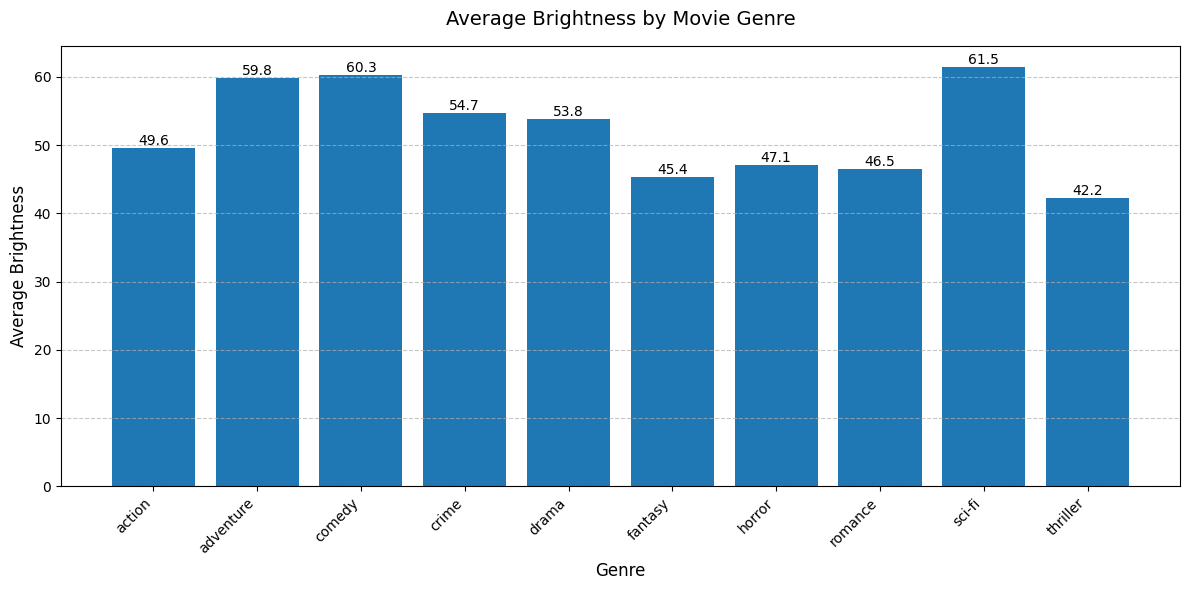

In [61]:
import copy
genre_to_brightness = copy.deepcopy(genre_to_youtube_ids)

for genre in genres:
    for i in range(len(genre_to_youtube_ids[genre])):
        youtube_id = genre_to_youtube_ids[genre][i]
        if youtube_id in brightness_results.keys():
            genre_to_brightness[genre][i] = brightness_results[youtube_id]
        # If not, means that the download failed, so we will use nan to mark as skipped
        else:
            genre_to_brightness[genre][i] = np.nan
        
    # # Average the brightness values
    genre_to_brightness[genre] = float(np.nanmean(genre_to_brightness[genre]))

# Print the results to verify
print("Average brightness by genre:")
print(genre_to_brightness)

# Plot the results
import matplotlib.pyplot as plt
# genres are already sorted and available
brightness_values = list(genre_to_brightness.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(genres, brightness_values)

# Customize the plot
plt.title('Average Brightness by Movie Genre', fontsize=14, pad=15)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Brightness', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## 3. Analyze the most/least common colors
Lastly, we will process the trailer in similar way we did with brightness analysis. In this section, however, we will aggregate the occurrences of each color in the frames for each trailer. This statistic will then be aggregated with other trailers of the same type to produce final histogram, which we will choose to visualize `top_k` result.

In [100]:
# from https://stackoverflow.com/questions/3241929/how-to-find-the-dominant-most-common-color-in-an-image
from sklearn.cluster import MiniBatchKMeans

def get_dominant_colors(
        video_path,
        color_count=10,
        top_k=10,
        downsample=5,
        size_reduction_factor=2
    ):
    cap = cv2.VideoCapture(video_path)
    pixels = []
    frame_count = 0
    
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return None
    
    # Read until video is completed
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # resize for speed
        copied_frame = frame.copy()
        copied_frame.resize(
            (300, 300)
        )

        if frame_count % downsample == 0:
            pixels.extend(copied_frame.reshape(-1, 3))
        frame_count += 1

    cap.release()

    ar = np.asarray(pixels).astype(float).reshape(-1, 3)
    kmeans = MiniBatchKMeans(
        n_clusters=color_count,
        init='k-means++',
        max_iter=20,
        random_state=seed_num
    ).fit(ar)
    colors = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    # Calculate percentage of pixels in each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    percentages = counts / len(labels) * 100
    
    # Sort colors by their frequency and get top_k
    sorted_idx = np.argsort(percentages)[::-1][:top_k]
    colors = colors[sorted_idx]
    percentages = percentages[sorted_idx]
    
    return [(tuple(map(int, color)), pct) for color, pct in zip(colors, percentages)]


In [69]:
def visualize_color_palette(colors_with_percentages, title):
    # Create figure
    plt.figure(figsize=(10, 4))
    
    # Create color patches
    for i, (color, percentage) in enumerate(colors_with_percentages):
        plt.bar(i, 100, color=np.array(color[::-1])/255, width=1)  # Convert BGR to RGB
        
        # Add percentage text
        plt.text(i, 50, f'{percentage:.1f}%', 
                ha='center', va='center',
                color='white' if sum(color) < 380 else 'black')
    
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

For example, if we run the function to get the color palettes for all trailers, we will get something like this.

Processing trailers...


100%|██████████| 24/24 [14:58<00:00, 37.45s/it]


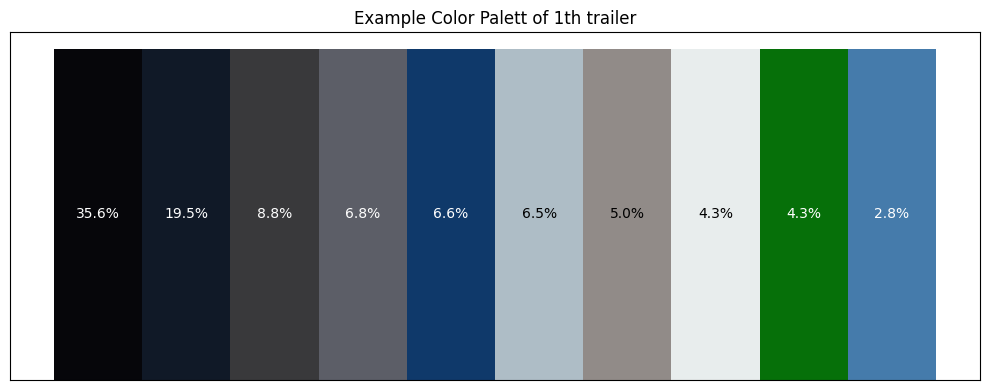

In [105]:
# Dictionary to store results
color_results = {}

print("Processing trailers...")
for filename in tqdm(os.listdir('data/trailers')):
    if filename.endswith('.mp4'):
        youtube_id = filename[:-4]
        video_path = os.path.join('data/trailers', filename)
        
        # Analyze colors
        colors_with_percentages = get_dominant_colors(video_path)
        if colors_with_percentages:
            color_results[youtube_id] = colors_with_percentages

# Function to convert BGR to RGB hex for readable output
colors_with_perc_example = list(color_results.values())[0]
visualize_color_palette(colors_with_perc_example, "Example Color Palett of 1th trailer")

And we then aggregate the color counts for each genre.

In [116]:
# Create a dictionary to store color frequencies for each genre
genre_colors = {genre: [] for genre in genres}

# Aggregate colors from all movies in each genre
for youtube_id, colors in color_results.items():
    # Get the movie ID from youtube_id
    if youtube_id in youtube_movie_ids_map:
        mid = youtube_movie_ids_map[youtube_id]
        mid = 'tt' + mid
        # Get the genres this movie belongs to
        movie_row = sampled_df[sampled_df['mid'] == mid]
        
        # For each genre this movie belongs to
        for genre in genres:
            if movie_row[genre].iloc[0] == 1:  # if movie belongs to this genre
                # Add colors with their percentages to this genre
                genre_colors[genre].extend(colors)

def color_distance(color1, color2):
    """Calculate Euclidean distance between two BGR colors"""
    return np.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(color1, color2)))

# Function to combine similar colors and their percentages
def combine_colors(color_list, similarity_threshold=40):
    # Convert list of (color, percentage) to dictionary
    color_dict = {}
    for color, percentage in color_list:
        color_key = tuple(color)  # Convert color array to tuple for dictionary key
        # Check if there's a similar color already in the dictionary
        similar_color_found = False
        for existing_color in list(color_dict.keys()):  # Create list to avoid runtime modification issues
            if color_distance(color_key, existing_color) < similarity_threshold:
                # Add percentage to the existing similar color
                color_dict[existing_color] += percentage
                similar_color_found = True
                break
        
        # If no similar color found, add this as a new color
        if not similar_color_found:
            color_dict[color_key] = percentage
    
    # Convert back to list and sort by percentage
    combined = [(color, perc) for color, perc in color_dict.items()]
    combined.sort(key=lambda x: x[1], reverse=True)
    
    # Normalize percentages
    total = sum(perc for _, perc in combined)
    normalized = [(color, (perc/total)*100) for color, perc in combined]
    
    return normalized

# Get dominant colors for each genre
genre_dominant_colors = {}
for genre in genres:
    if genre_colors[genre]:  # if we have colors for this genre
        genre_dominant_colors[genre] = combine_colors(genre_colors[genre]) # get top 10 colors

# Function to convert BGR to hex for visualization
def bgr_to_hex(bgr):
    return '#{:02x}{:02x}{:02x}'.format(bgr[2], bgr[1], bgr[0])

# Print results
print("Dominant colors by genre:")
for genre, colors in genre_dominant_colors.items():
    print(f"\n{genre}:")
    for color, percentage in colors:
        hex_color = bgr_to_hex(color)
        print(f"Color {hex_color}: {percentage:.2f}%")

Dominant colors by genre:

action:
Color #010101: 46.32%
Color #171c18: 16.84%
Color #3a3932: 8.84%
Color #727a70: 6.21%
Color #96a8a0: 5.63%
Color #d1d7c9: 4.95%
Color #77513b: 3.00%
Color #4c5d4f: 1.95%
Color #2c6969: 1.85%
Color #6c231d: 1.34%
Color #f7f9f8: 1.08%
Color #86783a: 0.59%
Color #006210: 0.57%
Color #c3422f: 0.39%
Color #cb9555: 0.32%
Color #1fc291: 0.11%

adventure:
Color #08090b: 46.04%
Color #423b3a: 18.39%
Color #6b5e50: 8.10%
Color #8c8474: 7.31%
Color #b1a993: 5.83%
Color #dbd4bc: 4.21%
Color #262919: 1.53%
Color #38427f: 1.45%
Color #80a9cb: 1.27%
Color #a2c3df: 0.92%
Color #6c231d: 0.89%
Color #6084a2: 0.89%
Color #604e1c: 0.77%
Color #2f7279: 0.62%
Color #86783a: 0.49%
Color #f7f9f8: 0.46%
Color #8992a2: 0.42%
Color #c3422f: 0.33%
Color #1fc291: 0.09%

comedy:
Color #040402: 38.11%
Color #20292a: 18.86%
Color #3d413c: 12.46%
Color #636a6a: 8.42%
Color #8c8474: 3.92%
Color #92a7ae: 3.05%
Color #dbd4bc: 2.92%
Color #f4f4f2: 2.90%
Color #b1a993: 2.47%
Color #816450

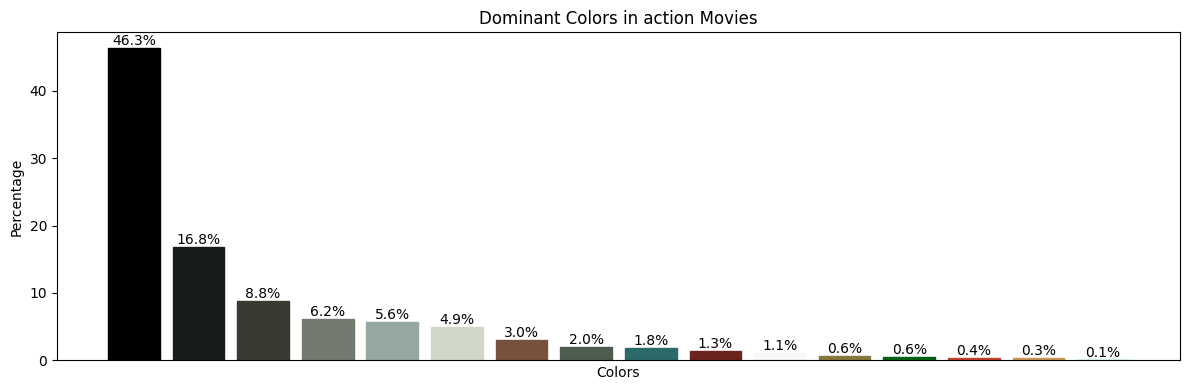

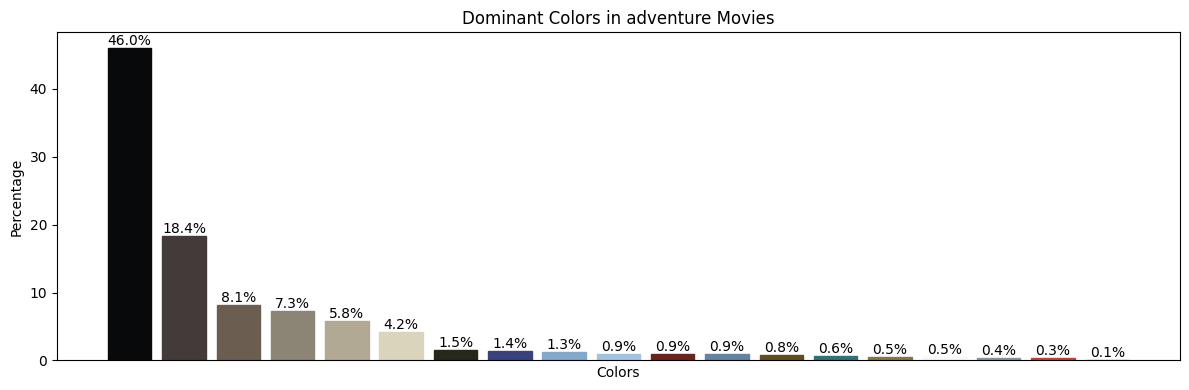

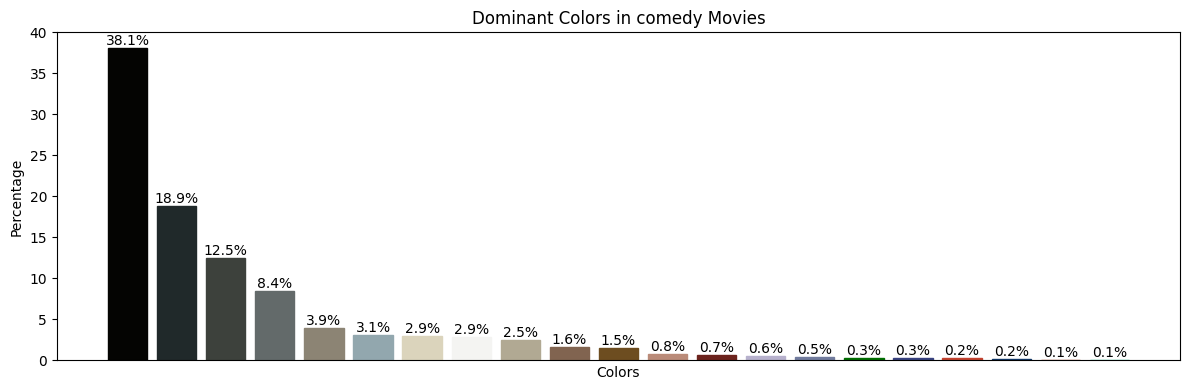

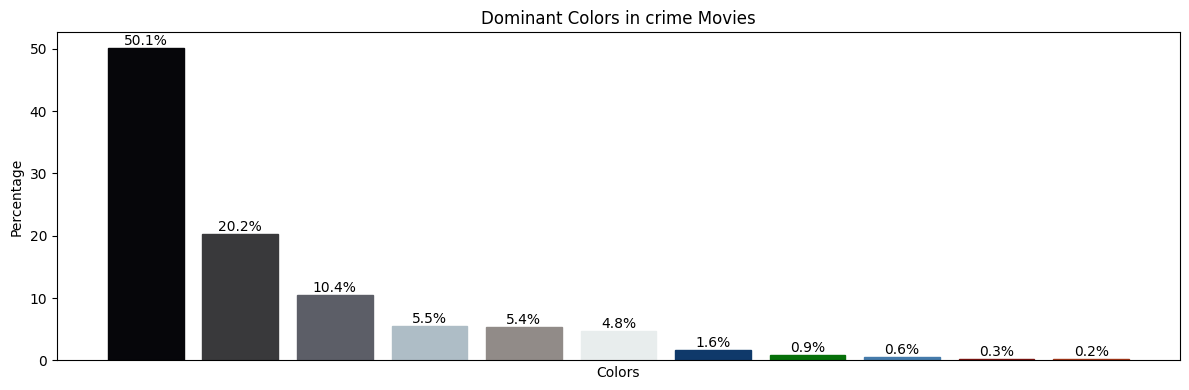

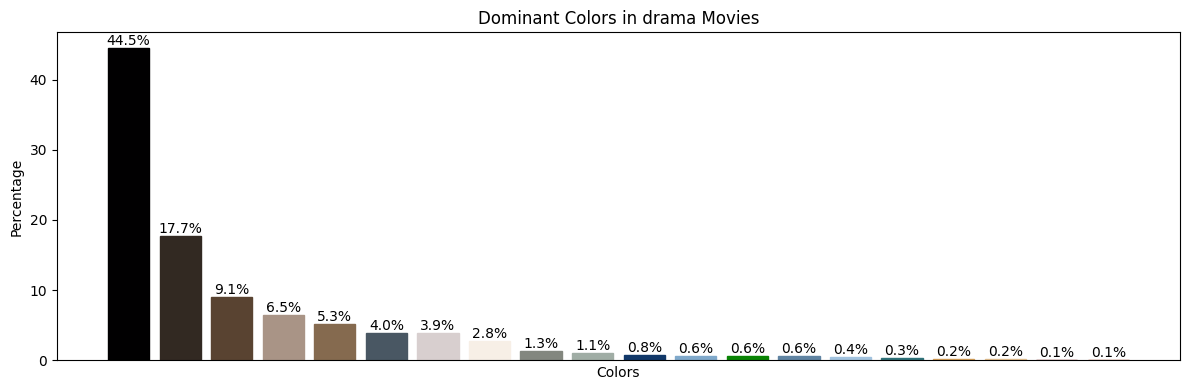

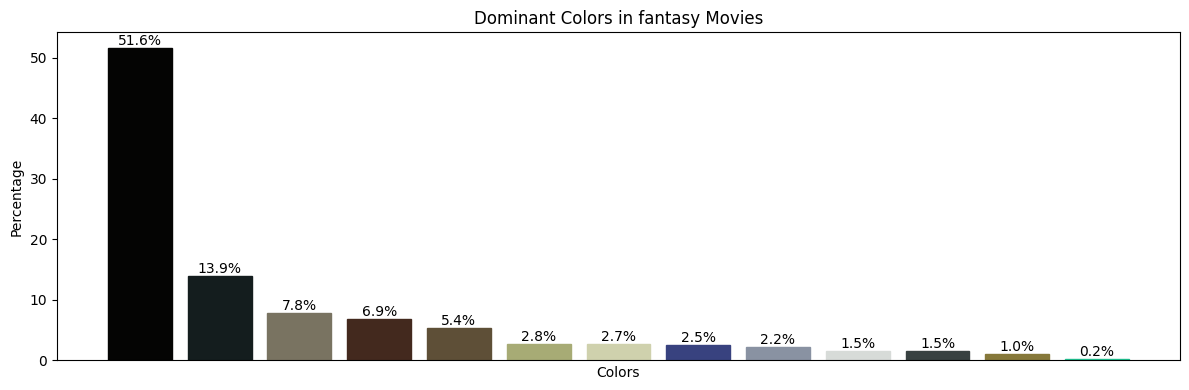

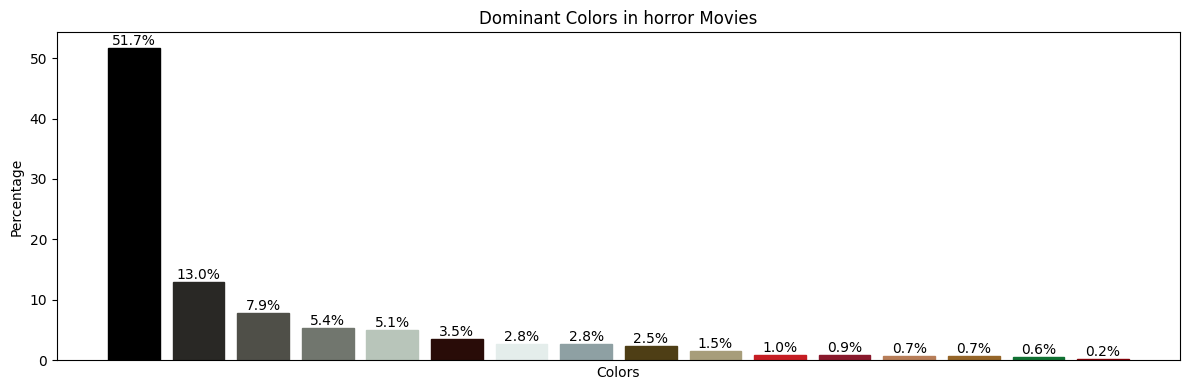

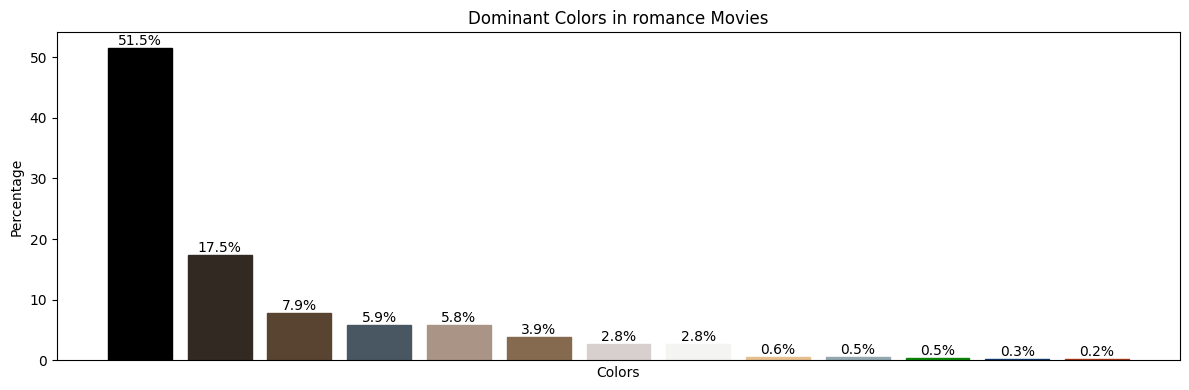

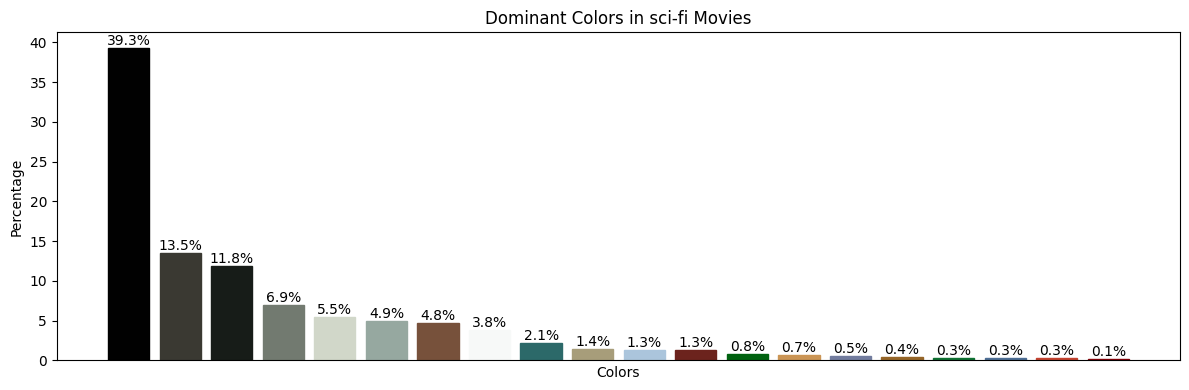

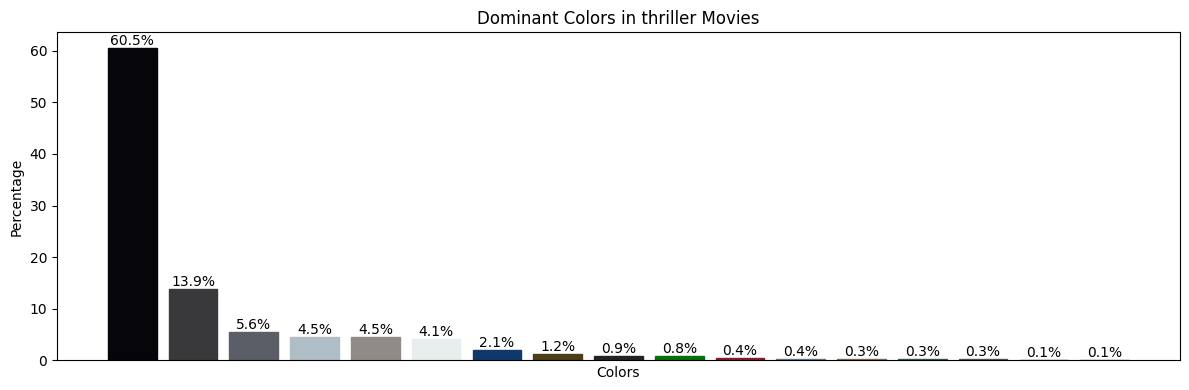

In [117]:
def plot_genre_colors(genre_colors, genre):
    plt.figure(figsize=(12, 4))
    
    colors = [color for color, _ in genre_colors]
    percentages = [percentage for _, percentage in genre_colors]
    
    # Create bars
    bars = plt.bar(range(len(colors)), percentages)
    
    # Color each bar with its corresponding color
    for bar, color in zip(bars, colors):
        # Convert BGR to RGB for matplotlib
        rgb_color = (color[2]/255, color[1]/255, color[0]/255)
        bar.set_color(rgb_color)
    
    plt.title(f'Dominant Colors in {genre} Movies')
    plt.xlabel('Colors')
    plt.ylabel('Percentage')
    plt.xticks([])  # Hide x-axis labels
    
    # Add percentage labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Plot for each genre
for genre, colors in genre_dominant_colors.items():
    plot_genre_colors(colors, genre)